# A Markovian model of evolving world IO network
https://sevamoo.github.io/Markovian_IO_SI_PLOSONE/

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from pylab import matshow, savefig
from scipy.linalg import norm
import time

## Supporting Functions

In [2]:
def update_by_momentum(series, span, pred_period):
    result = []  # first value is same as series
    vals = series[-span - 1:]
    for n in range(pred_period):
        momentum_avg = np.mean(np.diff(vals))
        result.append(vals[-1] + momentum_avg)
        vals[-1] = result[-1]

    return result

In [3]:
def aggregate_economy_int_consumptions(WIOT):
    economy_n = 41
    industry_n = 35
    economy_int_consumptions_n = 1
    economy_produsction_costs_n = 1
    states_n = economy_n * industry_n + economy_n * 1 + industry_n * 1

    economy_income = np.zeros((economy_n * industry_n, economy_n))
    economy_int_consumptions = np.zeros((economy_n * industry_n, economy_n))
    ind = economy_n * industry_n
    for i in range(economy_n):
        # This data are stored in the last columns on the right side of WIOD.
        # They are in five subcategory that here we just sum them as the final consumption of the government (inc. households)
        col = i * 5 + ind
        economy_int_consumptions[:, i] = WIOT[:, col:col + 5].sum(axis=1)

    # I don't know why but sometimes it gets a bit negative?!!! due to change in inventory (5th column of economy consum)
    economy_int_consumptions[economy_int_consumptions < 0] = 0

    # This is Tax, Payments, ...
    industry_production_costs = np.around(
        WIOT[:].sum(axis=1) - WIOT[:, :economy_n * industry_n].sum(axis=0), decimals=5)

    return (economy_int_consumptions, industry_production_costs)

In [4]:
def build_markov_chain_Dense(
        Q,
        WIOT,
        economy_n,
        industry_n,
        economy_int_consumptions,
        industry_production_costs,
):
    e0 = time.time()
    eps = .001

    for i in range(0, economy_n * industry_n):

        # For industry interactions
        for j in range(0, economy_n * industry_n):
            Q[i, j] = WIOT[j, i]

        # For payments of industry to its economy: This is the source of income for the economy
        economy_ind_industry = i // industry_n
        Q[i, economy_n * industry_n + economy_ind_industry] = industry_production_costs[i]

        # For economy's costs (i.e. consumptions)
        ind_economy_inTM = economy_n * industry_n

        for j in range(economy_n):
            Q[j + ind_economy_inTM, i] = economy_int_consumptions[i, j]

    # We have row stochastic matrix! In the paper we have column stochastic!
    singular_industries = []
    for i in range(Q.shape[0]):
        s = sum(Q[i])

        if np.sum(Q[i] > 0) == 1:
            if np.where(Q[i] > 0) == i:

                # means absorbing state
                Q[i] = eps
                Q[i, i] = 1.
                s = sum(Q[i])
                Q[i] = np.divide(Q[i], s)
            else:
                pass
            # print(np.where(Q[i] > 0), i, np.sum(Q[:, i] > 0))

        if s == 0:
            singular_industries.append(i % economy_n)
            Q[i] = eps
            Q[i, i] = 1.
            s = sum(Q[i])
            Q[i] = np.divide(Q[i], s)
        else:
            Q[i] = np.divide(Q[i], s)
    print('Making the TM in {} second'.format(time.time() - e0))

    return (np.around(Q, decimals=10), list(np.unique(singular_industries)))

In [5]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [6]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [7]:
# Sensitivity analysis on a single node
def change_node(M,
                economy_to_perturb=None,
                industry_to_perturb=None,
                percent=10):
    MC = M.copy()
    
    ind_indusrty_to_perturb_from_their_economy = []
    ind_indusrty_to_perturb_from_specific_industry = []

    if industry_to_perturb == industry_n:
        i = industry_n * economy_n + economy_to_perturb
    else:
        i = industry_to_perturb + (economy_to_perturb) * industry_n
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

## Load Dataset

In [8]:
economy_n = 41
industry_n = 35
header = pd.read_csv('./markov/Data/WIOD/header.csv', header=None)
economy_names = header.values[1, range(0, 1435, 35)]
industry_names = header.values[0, range(0, 35)]

In [9]:
Countries = pd.read_csv("./markov/Data/WIOD/Economies_Names.csv")

In [10]:
# We calculated this before from the WIOD, for GDP calculations
VA = pd.read_csv('./markov/Data/WIOD/VAs.csv', index_col=[0])

In [11]:
WIO = list()
for i in range(1995, 2012):
    d = pd.read_csv(
        './markov/Data/WIOD/wiot' + str(i) + '_row_apr12.csv', header=[0, 1, 2])
    WIO.append(d.values[:])
    print(i, d.shape)

1995 (1435, 1640)
1996 (1435, 1640)
1997 (1435, 1640)
1998 (1435, 1640)
1999 (1435, 1640)
2000 (1435, 1640)
2001 (1435, 1640)
2002 (1435, 1640)
2003 (1435, 1640)
2004 (1435, 1640)
2005 (1435, 1640)
2006 (1435, 1640)
2007 (1435, 1640)
2008 (1435, 1640)
2009 (1435, 1640)
2010 (1435, 1640)
2011 (1435, 1640)


## Using Power Iteration to calculate the steady state probabilities, Pi

In [12]:
Pi = []
TMs = []
Mixing_times = []
singular_ids = []

for i, WIOT in enumerate(WIO):
    economy_int_consumptions, industry_production_costs = aggregate_economy_int_consumptions(WIOT)
    economy_n = 41
    industry_n = 35
    states_n = economy_n * industry_n + economy_n
    TM = np.zeros((states_n, states_n))
    TM, singular_id = build_markov_chain_Dense(TM, WIOT, economy_n, industry_n,
                                               economy_int_consumptions,
                                               industry_production_costs)
    TMs.append(TM)
    singular_ids.extend(singular_id)
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

singular_ids = np.unique(singular_ids)

Making the TM in 1.716916799545288 second
Iterating 290 times in 0.2266082763671875
Making the TM in 1.787172555923462 second
Iterating 257 times in 0.1596055030822754
Making the TM in 1.6952834129333496 second
Iterating 251 times in 0.15274667739868164
Making the TM in 1.6367242336273193 second
Iterating 258 times in 0.16451072692871094
Making the TM in 1.6395723819732666 second
Iterating 263 times in 0.17798638343811035
Making the TM in 1.7659242153167725 second
Iterating 241 times in 0.1650705337524414
Making the TM in 1.8099346160888672 second
Iterating 228 times in 0.14390969276428223
Making the TM in 1.6691675186157227 second
Iterating 228 times in 0.1654801368713379
Making the TM in 1.6700799465179443 second
Iterating 222 times in 0.1690075397491455
Making the TM in 1.7814321517944336 second
Iterating 207 times in 0.19237327575683594
Making the TM in 1.6589469909667969 second
Iterating 190 times in 0.12221240997314453
Making the TM in 1.6355900764465332 second
Iterating 172 time

## Average mixing time of Markov chains as an aggregate index of globalization

In [13]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 100
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in range(n):
    for j in range(len(TMs)):
        t, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

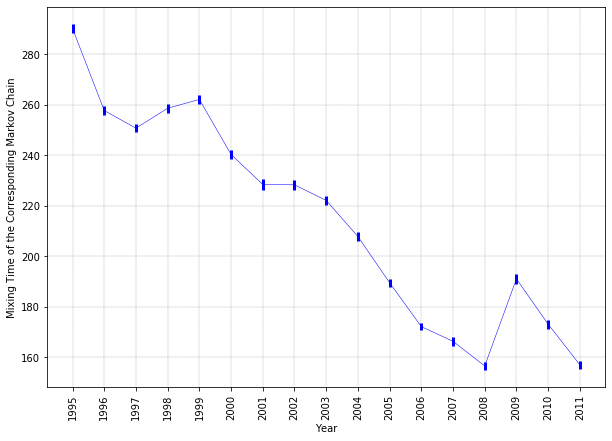

In [14]:
fig = plt.figure(figsize=(10, 7));
yerr = 3 * Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(1, 18),
    Mixing_times_n_times.mean(axis=0),
    yerr=yerr,
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.51,
    elinewidth=3)
plt.xticks(range(1, 18), range(1995, 2012))
label = range(1995, 2012)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
plt.xlabel('Year')
plt.xticks(range(1, 18), label, rotation=90)

plt.grid(linewidth=.31, color='gray', linestyle='--')
path = './markov/Images/Mixing_Time.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## Kemeny constants of Markov chains as an aggregate index of globalization

In [15]:
Kemenys = []
for TM in TMs:
    K, pi = Kemeny_constant(TM)
    Kemenys.append(K)

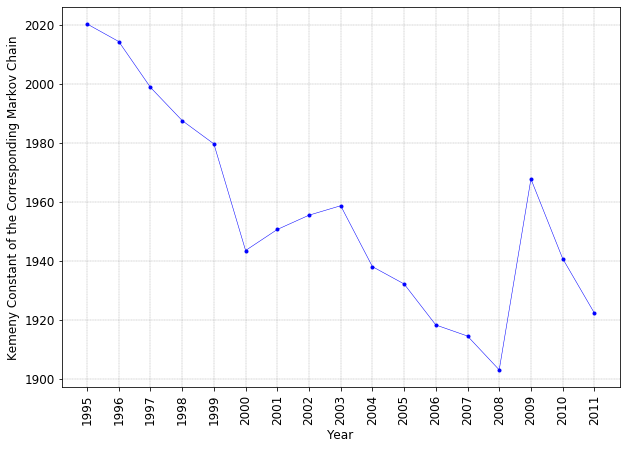

In [16]:
fig = plt.figure(figsize=(10, 7));
plt.plot(Kemenys, '.-b', linewidth=.51)
label = range(1995, 2012)
plt.xticks(range(17), label, rotation=90)
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
font = {'size': 12}
plt.rc('font', **font)
path = './markov/Images/Kemeny.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## GDP share of economies (red) compared to aggregated structural power (blue) over time

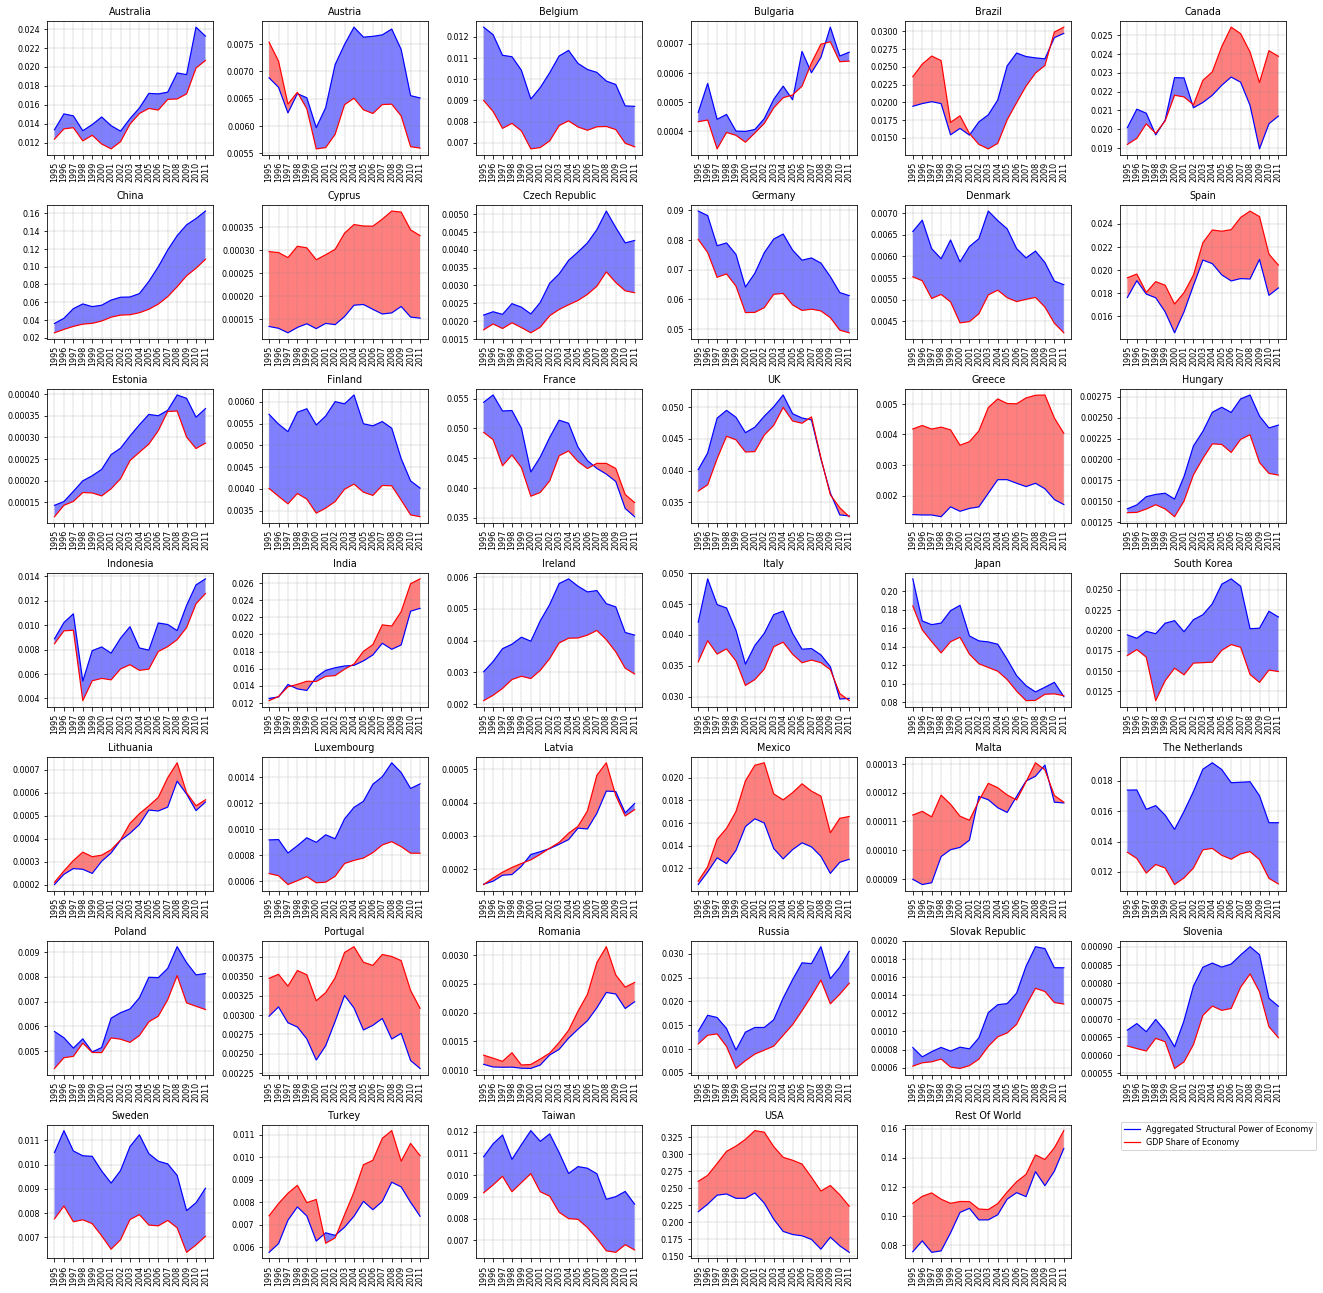

In [17]:
Data_all = np.asarray(Pi).T

fig = plt.figure(figsize=(18, 18))
font = {'size': 8}
plt.rc('font', **font)
GDP_shares = np.zeros((economy_n, 17))
Economies_shares = np.zeros((economy_n, 17))
for i in range(economy_n):
    ind_indusrty = range(i * industry_n, (i + 1) * industry_n)
    GDP_shares[i] = VA.values[:, ind_indusrty].sum(axis=1) / VA.values[:].sum(
        axis=1)

    plt.subplot(7, 6, i + 1)
    plt.title(Countries.Country[i])
    ind_indusrty = list(range(i * industry_n,
                         (i + 1) * industry_n)) + [industry_n * economy_n + i]
    Economies_shares[i] = Data_all[ind_indusrty].T.sum(axis=1)

    plt.plot(
        range(17),
        Economies_shares[i],
        '-b',
        linewidth=1.2,
        label='Aggregated Structural Power of Economy');
    plt.plot(
        range(17),
        GDP_shares[i],
        '-r',
        linewidth=1.2,
        label='GDP Share of Economy');
    y1 = Economies_shares[i]
    y2 = GDP_shares[i]
    x = range(17)

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)
    path = './markov/Images/GDP_Share_Pi.tiff'
    label = range(1995, 2012)
    plt.xticks(range(17), label, rotation=90)

    plt.tight_layout()

    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(2.5, 1.05))
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## Predicted trends of structural potential of different economies

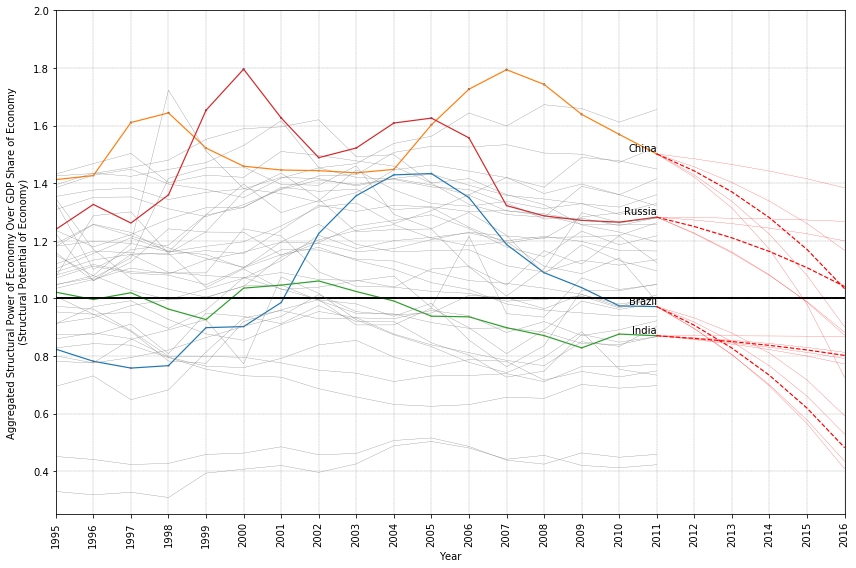

In [22]:
fig = plt.figure(figsize=(12, 8))

min_x = np.min(Economies_shares[:, :] / GDP_shares[:, :])
min_y = np.min(GDP_shares[:, :])

max_x = np.max(Economies_shares[:, :] / GDP_shares[:, :])
max_y = np.max(GDP_shares[:, :])
eps = .02

for c in range(economy_n):

    x = Economies_shares[c, :]
    color = Economies_shares[c, :] / GDP_shares[c, :]
    x = range(17)
    y = GDP_shares[c, :]
    y = Economies_shares[c, :]
    y = Economies_shares[c, :] / GDP_shares[c, :]

    min_x = np.min(Economies_shares[c, :])
    min_y = np.min(GDP_shares[c, :])
    min_min = np.min([min_x, min_y])

    max_x = np.max(Economies_shares[c, :])
    max_y = np.max(GDP_shares[c, :])
    max_max = np.max([max_x, max_y])
    eps = .02

    ax = plt.gca()
    pred_period = 5
    col = 0
    if Countries.Country[c] in ["Brazil", "Russia", "China", "India"]:
        ax.plot(x, y, '-', linewidth=1.2)

        all_preds = []
        for span in range(3, 7):
            series = y.copy()

            y_pred = update_by_momentum(series, span, pred_period)
            all_preds.append(y_pred)
            y_pred = list(y[-1:]) + y_pred
            x_pred = list(x[-1:]) + list(range(17, 17 + pred_period))
            ax.plot(x_pred, y_pred, '-r', linewidth=0.2)
        y_pred = list(y[-1:]) + list(np.median(all_preds, axis=0))
        x_pred = list(x[-1:]) + list(range(17, 17 + pred_period))
        ax.plot(x_pred, y_pred, '--r', linewidth=1.2)

        ax.scatter(
            x,
            y,
            vmax=1.7,
            vmin=0.5,
            c=color,
            s=20,
            marker='.',
            edgecolor='None',
            cmap='RdYlBu',
            alpha=1)
        ax.annotate(
            Countries.Country[c],
            size=10,
            xy=(x[16], y[-1] + .002),
            xytext=(0, 0),
            textcoords='offset points',
            ha='right',
            va='bottom')
    else:
        ax.plot(x, y, 'gray', linewidth=.3)

    ax.plot([0, 16 + pred_period], [1, 1], '--k', linewidth=.2)

    plt.ylim([.25, 2])
    plt.xlim([0, 16 + pred_period])

    plt.ylabel(
        'Aggregated Structural Power of Economy Over GDP Share of Economy\n (Structural Potential of Economy)'
    )
    plt.xlabel('Year')
    plt.xticks(
        range(17 + pred_period),
        range(1995, 2012 + pred_period),
        rotation='vertical')

    plt.grid(linewidth=.31, color='gray', linestyle='--')
    plt.tight_layout()
    font = {'size': 10}
    plt.rc('font', **font)
    path = './markov/Images/GDP_Share_Vs_Pi_Share_trend.tiff'

# fig.savefig(path,dpi=300)

## Sensitivity analysis of Markov chains

In [18]:
# This takes a lot of time to run. In the next section, you can use the produced data

ind_selected_economy = np.arange(economy_n)
ind_selected_economy

How_much_change = -99

# tminds = [4, 9, 14, 16]
tminds = [1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15]

for tmind in tminds:
    TM = TMs[tmind]
    name_perturbed = []
    Wrong_TM = []
    Kemenys_perturbed = []
    Pi_perturbed = []
    Pi_diff = []
    ind = []
    names = []
    e0 = time.time()
    K_normal, pi_normal = Kemeny_constant(TM)
    for economy in ind_selected_economy:
        for industry in range(industry_n):
            economy_to_perturb = economy
            industry_to_perturb = industry
            name_perturbed.append(Countries.Country[economy_to_perturb] + '-' +
                                  industry_names[industry_to_perturb])

            Perturbed_TM = change_node(
                TM,
                economy_to_perturb=economy_to_perturb,
                industry_to_perturb=industry_to_perturb,
                percent=How_much_change)

            K, pi = Kemeny_constant(Perturbed_TM)
            pi, mixing_ = simulate_markov(Perturbed_TM, verbose='off')
            Init_Pi = pi
            if np.any(pi < 0):
                Wrong_TM.append(Perturbed_TM[industry_to_perturb +
                                             (economy_to_perturb) * industry_n])
                print('something went wrong!')
            else:
                #we don't calculate the kemeny any longer
                Kemenys_perturbed.append(K)
                ind.append(industry + economy_n * industry_n)
                Pi_perturbed.append(Init_Pi)
                Pi_diff.append(
                    np.asarray(100 * (Init_Pi - pi_normal) / pi_normal))

    #For Governments
    for economy in ind_selected_economy:
        economy_to_perturb = economy
        industry_to_perturb = industry_n
        name_perturbed.append(
            Countries.Country[economy_to_perturb] + "-Government")
        Perturbed_TM = change_node(
            TM,
            economy_to_perturb=economy_to_perturb,
            industry_to_perturb=industry_to_perturb,
            percent=How_much_change)

        K, pi = Kemeny_constant(Perturbed_TM)
        pi, mixing_ = simulate_markov(Perturbed_TM, verbose='off')
        Init_Pi = pi
        if np.any(pi < 0):
            Wrong_TM.append(Perturbed_TM[industry_to_perturb +
                                         (economy_to_perturb) * industry_n])
            print('something went wrong!')
        else:
            Kemenys_perturbed.append(K)
            ind.append(industry + economy_n * industry_n)
            Pi_perturbed.append(Init_Pi)
            Pi_diff.append(np.asarray(100 * (Init_Pi - pi_normal) / pi_normal))

    print("Sensitivity of TM {}, in {} second".format(1995 + tmind,
                                                      time.time() - e0))

    columns = []
    for eco in Countries.Country:
        for ind in industry_names:
            columns.append(eco + "-" + ind)
    for eco in Countries.Country:
        columns.append(eco + "-Government")

    DF = pd.DataFrame(
        index=name_perturbed, data=np.asarray(Pi_diff), columns=columns)
    path = "./markov/Data/myWIOD/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(1995 + tmind) + ".csv"
    DF.to_csv(path_or_buf=path, header=True, index=True)

    DF = pd.DataFrame(
        index=['pi_normal'],
        data=np.asarray(pi_normal)[np.newaxis, :],
        columns=columns)
    path = "./markov/Data/myWIOD/pi_normal_How_much_change_" + str(
        How_much_change) + "_year_" + str(1995 + tmind) + ".csv"
    DF.to_csv(path_or_buf=path, header=True, index=True)

    DF = pd.DataFrame(
        index=name_perturbed,
        data=np.asarray(100 * (Kemenys_perturbed - K) / K),
        columns=['Kemeny_Change_PCT'])
    path = "./markov/Data/myWIOD/Kemeny_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(1995 + tmind) + ".csv"
    DF.to_csv(path_or_buf=path, header=True, index=True)

    DF = pd.DataFrame(
        index=name_perturbed, data=np.asarray(Pi_perturbed), columns=columns)
    path = "./markov/Data/myWIOD/pi_perturbed_How_much_change_" + str(
        How_much_change) + "_year_" + str(1995 + tmind) + ".csv"
    DF.to_csv(path_or_buf=path, header=True, index=True)

Sensitivity of TM 1996, in 3868.61509680748 second
Sensitivity of TM 1997, in 3840.8406496047974 second
Sensitivity of TM 1998, in 3199.62900185585 second
Sensitivity of TM 2000, in 3178.309963941574 second
Sensitivity of TM 2001, in 3243.968003511429 second
Sensitivity of TM 2002, in 4077.0182554721832 second
Sensitivity of TM 2003, in 4044.2437105178833 second
Sensitivity of TM 2005, in 3649.2865595817566 second
Sensitivity of TM 2006, in 3859.1379408836365 second
Sensitivity of TM 2007, in 4132.147431135178 second
Sensitivity of TM 2008, in 3982.3578238487244 second
Sensitivity of TM 2010, in 3534.9768245220184 second


## The effect of 99% slowdown of electrical and optical equipment industry of China

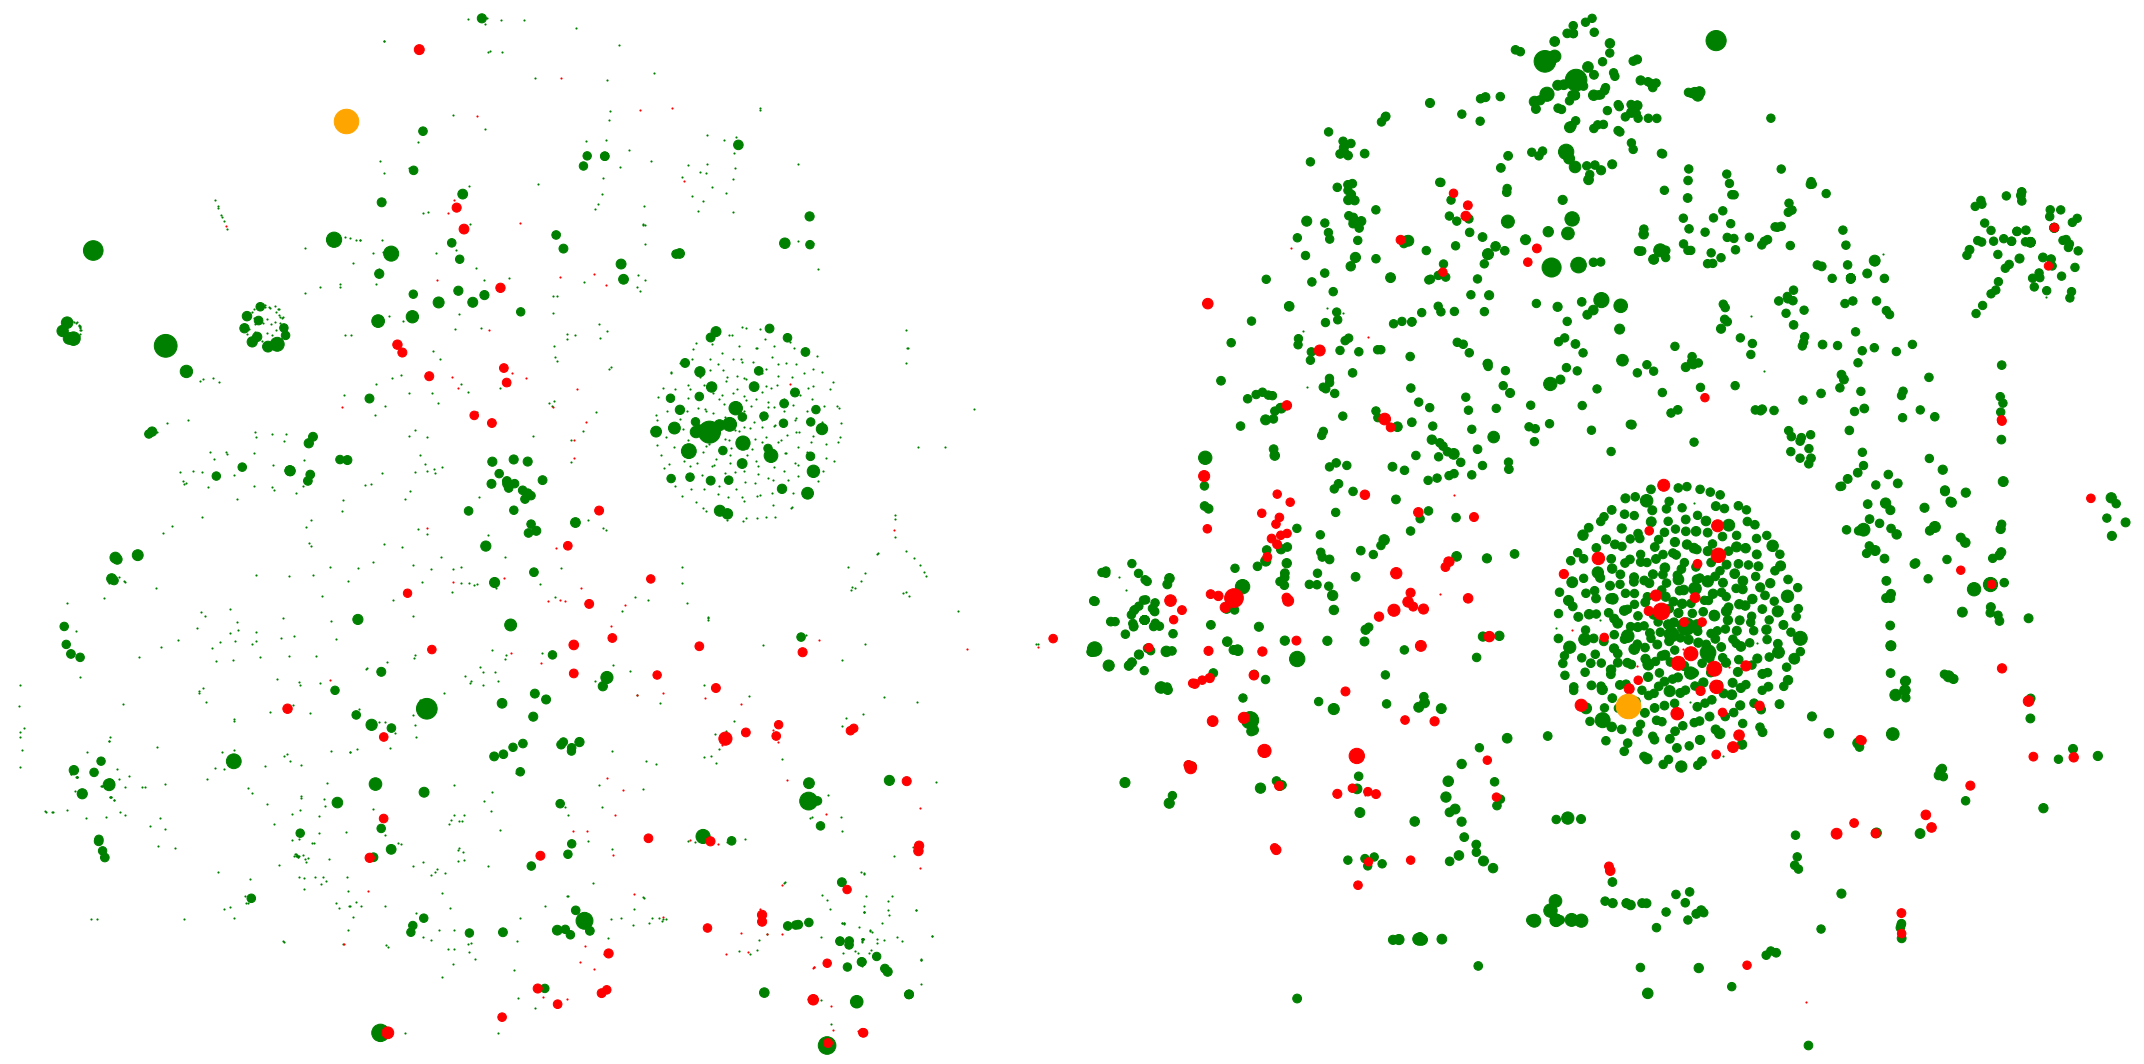

In [30]:
fig = plt.figure(figsize=(30, 15))

for i, year in enumerate([1996, 2010]):
    plt.subplot(1, 2, i + 1)
    whichvector = 'Export'
    whichyearnetwork = year
    pct_change_range = 1.0
    economyname = 'China'
    industryname = 'Electrical and Optical Equipment'

    pi_perturbedpath = "./markov/Data/myWIOD/pi_perturbed_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

    pi_normalpath = "./markov/Data/myWIOD/pi_normal_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_normal = pd.read_csv(pi_normalpath, index_col=0)

    pi_diff_path = "./markov/Data/myWIOD/PerturbationOnIndustries_Change_PCT_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_diff = pd.read_csv(pi_diff_path, index_col=0)

    pi_diff = pi_diff.loc[str(economyname + '-' + industryname)].values[:1435]
    perturbed = pi_perturbed.loc[str(
        economyname + '-' + industryname)].values[:1435]
    normal = pi_normal.values[0, :1435]

    path = "./markov/Data/perturb/Economy_map_" + whichvector + "_" + str(
        whichyearnetwork) + ".json"
    #now assume we have it
    import json
    with open(path) as data_file:
        data = json.load(data_file)
    NETWORK_RESULTS = data
    NETWORK_RESULTS = data
    NETWORK_RESULTS['pi_perturbed'] = list(perturbed * 1e4)
    NETWORK_RESULTS['pi_normal'] = list(normal * 1e4)
    NETWORK_RESULTS['pi_diff'] = list(pi_diff)

    ind_industry = set(
        np.where(np.asarray(NETWORK_RESULTS['industry']) == industryname)[0])
    ind_economy = set(
        np.where(np.asarray(NETWORK_RESULTS['economy']) == economyname)[0])
    indmainnode = list(ind_industry.intersection(ind_economy))[0]

    indsmall = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) < pct_change_range)[0]
    indsmed = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) >= pct_change_range)[0]

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmall]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmall]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmall]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=1.3, color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=1.3, color='r')

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmed]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmed]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmed]
    size = 70 + 3 * np.asarray(NETWORK_RESULTS['pi_normal']) / 1 * (
        1 + np.asarray(NETWORK_RESULTS['pi_diff']) / 100)
    size = size[indsmed]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=size[vals >= 0], color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=size[vals < 0], color='r')

    plt.scatter(
        np.asarray(NETWORK_RESULTS['XCoord'])[indmainnode],
        1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indmainnode],
        s=[600],
        color='orange')

    plt.xlim(-11, 1011)
    plt.ylim(-11, 1011)
    plt.axis('off')
    plt.tight_layout()

path = './markov/Images/perturb_china.tiff'
#fig.savefig(path,dpi=400)
plt.show();
plt.close();

## Systemic fragility vs. systemic influence of each industry for the year 2010

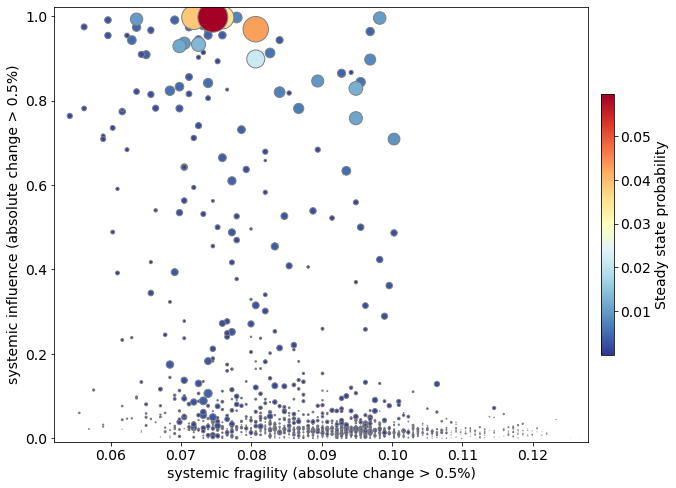

In [27]:
whichyearnetwork = 2010
How_much_change = -99

pi_perturbedpath = "./markov/Data/myWIOD/pi_perturbed_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

pi_normalpath = "./markov/Data/myWIOD/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

pi_diff_path = "./markov/Data/myWIOD/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_diff = pd.read_csv(pi_diff_path, index_col=0)

# Threshold of change in pct
thresh = .5

dim = pi_diff.shape[1]

# Systemic Influence
no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affecting = np.zeros(dim)
neg_affecting = np.zeros(dim)
for i in range(dim):
    pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_pos_affecting[i]])
    neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_neg_affecting[i]])

# We want to take out the effect each node on itself
self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]

sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)
pi_norm = pi_normal.values[0, :dim]

systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)

# Systemic Fragility
no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affected = np.zeros(dim)
neg_affected = np.zeros(dim)

for i in range(dim):
    pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]
    neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]

systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float(dim)

sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()

x = systemic_fragility
y = systemic_influence

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)

plt.plot(x, y, 'ob', markersize=.3, alpha=.05)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min() - eps * .1
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Fragility_Influence.tiff'
# fig.savefig(path, dpi=300)

plt.show();
cb.remove()
plt.close();

## Paradoxical effects of slowing down the activity of economic nodes on Kemeny constant

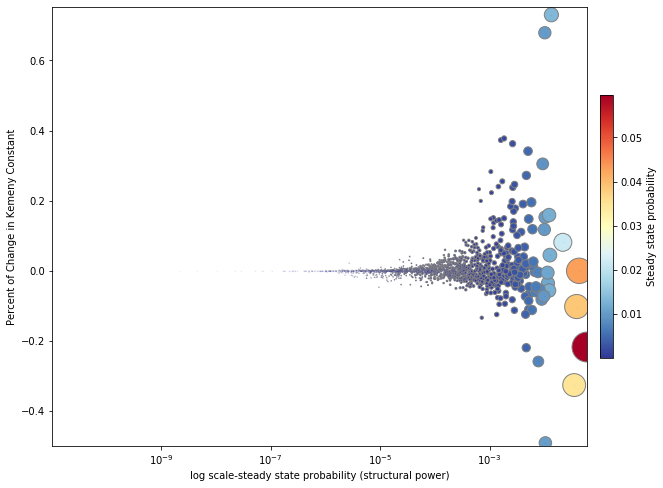

In [28]:
%matplotlib inline
#KEMENY CHNAGE
whichyearnetwork = 2010
How_much_change = -99

Kemeny_Change_PCTpath = "./markov/Data/myWIOD/Kemeny_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

pi_normalpath = "./markov/Data/myWIOD/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

#Threshold of change in pct
thresh = .5

dim = pi_normal.shape[1]
pi_norm = pi_normal.values[0, :dim]

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()
ax.set_xscale('log')

x = pi_norm
y = Kemeny_Change_PCT.values[:dim]

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)


plt.plot(x, y, 'ob', markersize=.3, alpha=.099)

plt.xlabel('log scale-steady state probability (structural power)')
plt.ylabel('Percent of Change in Kemeny Constant')

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min()
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Kemeny_Eigen.tiff'
#fig.savefig(path, dpi=300)

plt.show();
plt.close();

## Calculating Systemic Influence, Systemic Fragility other measures from 1996 to 2010

In [31]:
How_much_change = -99
whichyearnetwork = 1996
Kemeny_Change_PCTpath = "./markov/Data/myWIOD/Kemeny_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

######################################
sys_fragility_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
sys_influence_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
Kemeny_Change_PCT_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
Pi_normall_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
outdegree_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
indegree_all = pd.DataFrame(index=Kemeny_Change_PCT.index)
######################################

for year in np.add(tminds, 1995):
    whichyearnetwork = year
    How_much_change = -99
    Kemeny_Change_PCTpath = "./markov/Data/myWIOD/Kemeny_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

    pi_perturbedpath = "./markov/Data/myWIOD/pi_perturbed_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

    pi_normalpath = "./markov/Data/myWIOD/pi_normal_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_normal = pd.read_csv(pi_normalpath, index_col=0)

    pi_diff_path = "./markov/Data/myWIOD/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
        How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
    pi_diff = pd.read_csv(pi_diff_path, index_col=0)

    # Systemic Influence Vs. Systemice Fragility
    # Threshold of change in pct
    thresh = .5
    dim = pi_diff.shape[1]

    # Systemic Influence
    no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
    no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)
    s = float(dim)

    ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)
    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]
    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(
        self_change)
    pi_norm = pi_normal.values[0, :dim]

    systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / s

    #Systemic Fragility
    no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

    ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affected = np.zeros(dim)
    neg_affected = np.zeros(dim)
    for i in range(dim):
        pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]
        neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / s

    sys_fragility_all[year] = systemic_fragility
    sys_influence_all[year] = systemic_influence
    Kemeny_Change_PCT_all[year] = Kemeny_Change_PCT.values[:]
    Pi_normall_all[year] = pi_normal.T.values[:]
    outdegree_all[year] = np.sum(TMs[year - 1995] > 0, axis=1)
    indegree_all[year] = np.sum(TMs[year - 1995] > 0, axis=0)

In [32]:
# Here we calculate the indiced of the nodes of Rest of the World (ROW) and the Governments.
# We remove them in some analyses.
i = 40
ind_ROW = list(range(i * industry_n,
                     (i + 1) * industry_n)) + [industry_n * economy_n + i]
ind_GOvs = range(industry_n * economy_n, industry_n * economy_n + economy_n)
ind_all = range(1476)
ind_all_except_ROW = list(set(ind_all).difference(ind_ROW))
ind_all_except_ROW_GOVS = list(set(ind_all_except_ROW).difference(ind_GOvs))

## The paradoxical effect of slowdown in the activity economic nodes

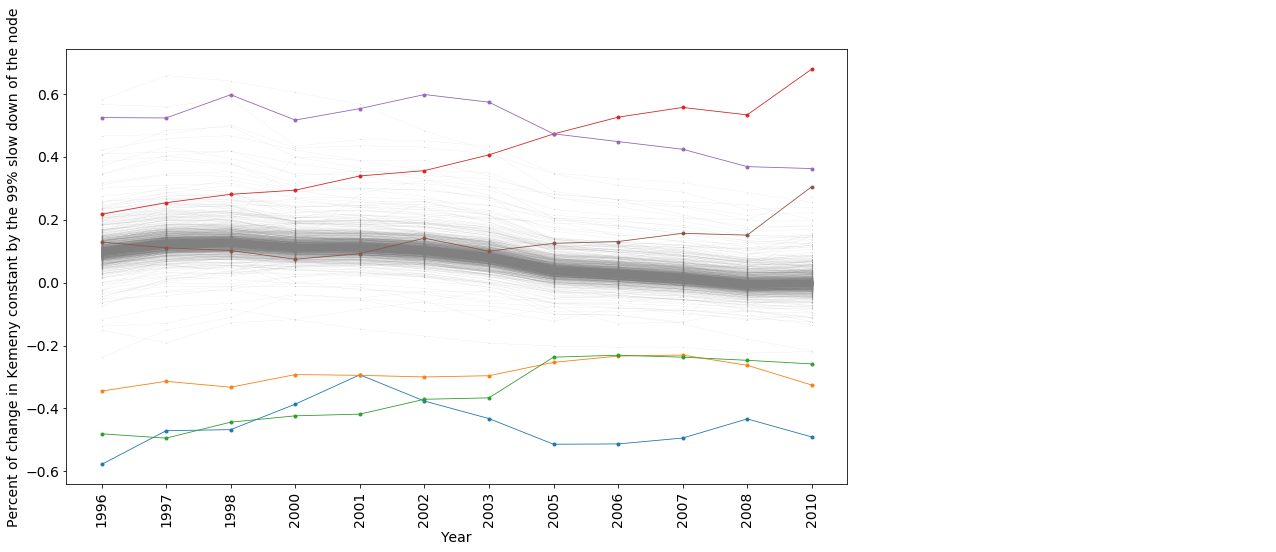

In [33]:
net_index = Kemeny_Change_PCT_all.loc[Kemeny_Change_PCT_all.index[
    ind_all_except_ROW]].copy()
DF = net_index.sort_values(1996, ascending=False)
positive1995 = DF.index[:10].values[:]

DF = net_index.sort_values(1996, ascending=True)
negative1995 = DF.index[:10].values[:]

DF = net_index.sort_values(2010, ascending=False)
positive2011 = DF.index[:10].values[:]

DF = net_index.sort_values(2010, ascending=True)
negative2011 = DF.index[:10].values[:]

fig = plt.figure(figsize=(14, 8))

plt.plot(
    net_index.values[:].T, '.-', color='gray', linewidth=.05, markersize=.2)

plt.plot(
    net_index.loc[negative2011[:3]].values[:].T, '.-', linewidth=.81)

plt.plot(
    net_index.loc[positive2011[:3]].values[:].T, '.-', linewidth=.81)

i = 0
y = net_index.loc[negative2011[i]][2010]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, 0),
    textcoords='offset points',
    ha='left',
    va='bottom')

i = 1
y = net_index.loc[negative2011[i]][2010]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, -12),
    textcoords='offset points',
    ha='left',
    va='bottom')

i = 2
y = net_index.loc[negative2011[i]][2010]
plt.annotate(
    negative2011[i],
    size=8,
    xy=(16, y + .002),
    xytext=(-10, 4),
    textcoords='offset points',
    ha='left',
    va='bottom')

for i in range(3):
    y = net_index.loc[positive2011[i]][2010]
    plt.annotate(
        positive2011[i],
        size=8,
        xy=(16, y + .002),
        xytext=(-23, 5),
        textcoords='offset points',
        ha='left',
        va='bottom')

plt.ylabel(
    'Percent of change in Kemeny constant by the 99% slow down of the node')
plt.xlabel('Year')
plt.xticks(
    range(12), np.add(tminds, 1995), rotation='vertical')
font = {'size': 14.}
plt.rc('font', **font)
path = './markov/Images/Percent_of_change_Kemeny.tiff'
# fig.savefig(path,dpi=300)

## Top 10 nodes with the highest systemic influence in 2010

In [34]:
year = 2010

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_fragility_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Systemic Influence', ascending=False)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Japan-Real Estate Activities,0.00519094,0.0738482,0.999322
2,USA-Government,0.0596473,0.0745257,0.99729
3,India-Government,0.00772209,0.0779133,0.996612
4,Japan-Government,0.0348361,0.0758808,0.996612
5,China-Government,0.0387326,0.0718157,0.996612
6,USA-Real Estate Activities,0.00889117,0.0731707,0.995935
7,"USA-Retail Trade, Except of Motor Vehicles and...",0.00526979,0.0731707,0.995257
8,Brazil-Government,0.0103834,0.0982385,0.995257
9,Japan-Renting of M&Eq and Other Business Activ...,0.00538111,0.0745257,0.99458
10,"USA-Wholesale Trade and Commission Trade, Exce...",0.00509373,0.0745257,0.993902


## Top 10 nodes with the lowest systemic fragility in 2010

In [35]:
year = 2010

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_fragility_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Systemic Fragility', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Finland-Electrical and Optical Equipment,0.000153301,0.0555556,0.0602981
2,USA-Electrical and Optical Equipment,0.00240215,0.0562331,0.974255
3,Germany-Electrical and Optical Equipment,0.0014399,0.0562331,0.781165
4,"Taiwan-Manufacturing, Nec; Recycling",3.76204e-05,0.0569106,0.0223577
5,UK-Electrical and Optical Equipment,0.000312539,0.0575881,0.114499
6,Denmark-Chemicals and Chemical Products,7.53032e-05,0.0589431,0.0277778
7,"Germany-Machinery, Nec",0.00169621,0.0589431,0.708672
8,"Denmark-Machinery, Nec",8.64405e-05,0.0589431,0.0325203
9,Germany-Chemicals and Chemical Products,0.00107441,0.0589431,0.716125
10,USA-Chemicals and Chemical Products,0.00273369,0.0596206,0.95393


## Top 10 nodes with the highest positive effects on Kemeny constant in 2010

In [37]:
year = 2010

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=False)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,China-Electrical and Optical Equipment,0.0101485,0.992547,0.678699
2,Germany-Transport Equipment,0.00261369,0.814363,0.362444
3,Russia-Government,0.00927446,0.708672,0.304861
4,China-Textiles and Textile Products,0.00466797,0.973577,0.271923
5,"Germany-Machinery, Nec",0.00169621,0.708672,0.255092
6,Germany-Electrical and Optical Equipment,0.0014399,0.781165,0.240216
7,Germany-Chemicals and Chemical Products,0.00107441,0.716125,0.222879
8,Romania-Government,0.000685267,0.0792683,0.199268
9,USA-Transport Equipment,0.00256404,0.909214,0.197728
10,USA-Electrical and Optical Equipment,0.00240215,0.974255,0.183646


## Top 10 nodes with the highest negative effects on Kemeny constant in 2010

In [38]:
year = 2010

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,Brazil-Government,0.0103834,0.995257,-0.490601
2,Japan-Government,0.0348361,0.996612,-0.325665
3,India-Government,0.00772209,0.996612,-0.258496
4,Mexico-Government,0.00464574,0.963415,-0.219225
5,USA-Government,0.0596473,0.99729,-0.217268
6,Greece-Government,0.000714617,0.0718157,-0.133661
7,Finland-Government,0.00134231,0.0948509,-0.124477
8,Indonesia-Government,0.00451024,0.864499,-0.124043
9,Sweden-Government,0.00282071,0.361789,-0.112519
10,Spain-Government,0.00589154,0.843496,-0.111675


## Top 10 industry nodes with the highest negative effects on Kemeny constant in 2010

In [39]:
year = 2010

dd = np.concatenate(
    (Pi_normall_all.index.values[:][:, np.newaxis],
     Pi_normall_all[year].values[:][:, np.newaxis],
     sys_influence_all[year].values[:][:, np.newaxis],
     Kemeny_Change_PCT_all[year].values[:][:, np.newaxis]),
    axis=1)
DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
    ])

DF = DF.loc[DF.index[ind_all_except_ROW_GOVS]]

DF.head()
DF = DF.sort_values('Pct of chng Kemeny', ascending=True)
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Influence,Pct of chng Kemeny
1,Japan-Real Estate Activities,0.00519094,0.999322,-0.11046
2,Brazil-Public Admin and Defence; Compulsory So...,0.00148776,0.0264228,-0.0952158
3,USA-Real Estate Activities,0.00889117,0.995935,-0.0818434
4,"India-Agriculture, Hunting, Forestry and Fishing",0.00157759,0.0758808,-0.0781171
5,Australia-Real Estate Activities,0.00139773,0.0135501,-0.0764688
6,Japan-Public Admin and Defence; Compulsory Soc...,0.00445932,0.954607,-0.0728571
7,France-Real Estate Activities,0.00198049,0.0223577,-0.0725904
8,Brazil-Real Estate Activities,0.00085837,0.0230352,-0.0658248
9,Japan-Renting of M&Eq and Other Business Activ...,0.00538111,0.99458,-0.0647839
10,Australia-Construction,0.00197333,0.0298103,-0.0630517


## Clustering the nodes

In [43]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
from sompy.sompy import SOMFactory
from sompy import mapview

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [44]:
msz10 = 50
msz11 = 50

Data = np.concatenate(
    (Pi_normall_all.values[:], Kemeny_Change_PCT_all[:],
     sys_fragility_all.values[:], sys_influence_all.values[:],
     indegree_all.values[:], outdegree_all.values[:]),
    axis=1)

In [46]:
names = []
for what in [
        'structural power', 'pct-change-Kemeny', 'fragility', 'influence',
        'indegree', 'outdegree'
]:
    for year in np.add(tminds, 1995):
        names.append(what + '-' + str(year))

In [47]:
sm = SOMFactory().build(
    Data, mapsize=[msz10, msz11], initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=2, train_finetune_len=5)

In [48]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

Topographic error = 0.0033875338753387536; Quantization error = 1.1920592627596376


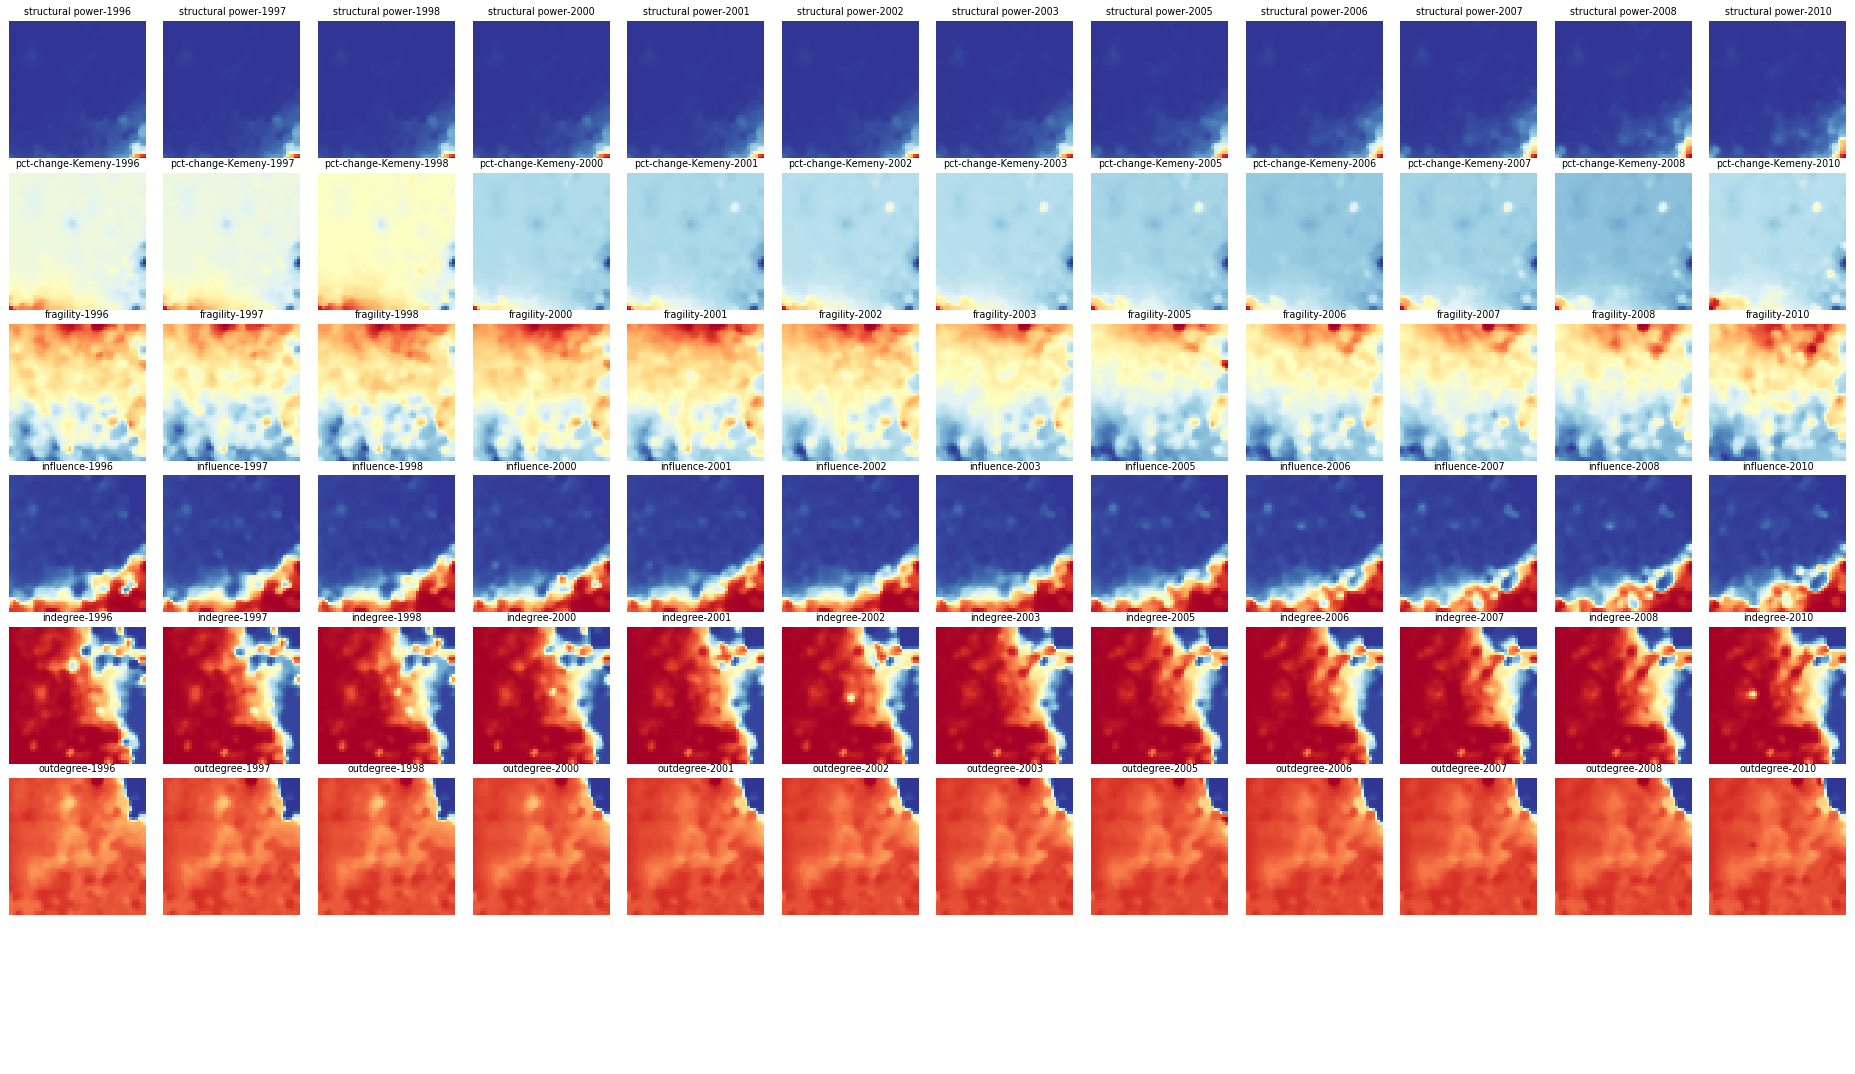

In [50]:
from sompy.visualization.mapview import View2DPacked
atlas = View2DPacked(20, 20, '', text_size=8)
atlas.show(sm, col_sz=12, which_dim="all")